In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os, sys

import matplotlib.pyplot as plt

In [11]:
## This are the configuration of all the parameters

ModelOutDIR = "Bsize64_lr5e-4_NOnormNodes/"
BatchSize = 1024
LearningRate = 0.0005
Epochs = 500


In [4]:
import os
## check if EOS folder exists otherwise use local folder
if os.path.exists("/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241113/"):
    GraphDIR = "/eos/cms/store/user/folguera/L1TMuon/INTREPID/Graphs_v240725_241113/"
else:
    GraphDIR = "../../data/"

graph_name = 'vix_graph_13Nov_3_muonQOverPt' #"vix_graph_13Nov_3_muonQOverPt" #vix_graph_6Nov_3_muonQOverPt
num_files = 20
Allgraphs = []
all_files = os.listdir(GraphDIR)

# Filter for .pkl files
graph_files = [f for f in all_files if (f.endswith('.pkl') or f.endswith('.pt')) and graph_name in f]
if not graph_files:
    print("No .pkl/.pt files found in the directory.")
    sys.exit()

graph_files = graph_files[:num_files]

graphs = []
for graph_file in graph_files:
    file_path = os.path.join(GraphDIR, graph_file)
    print(f"Loading file: {graph_file}")
    if graph_file.endswith('.pt'):
        graph = torch.load(file_path)
    elif graph_file.endswith('.pkl'):
        with open(file_path, 'rb') as file:
            graph = torch.load(file)
    graphs.append(graph)

Loading file: vix_graph_13Nov_3_muonQOverPt_001.pt


C:\Users\folguerassantiago\AppData\Local\Temp\ipykernel_2480\1996300641.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(file_path)


Loading file: vix_graph_13Nov_3_muonQOverPt_002.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_003.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_004.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_005.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_006.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_007.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_008.pt
Loading file: vix_graph_13Nov_3_muonQOverPt_009.pt


In [2]:
pip install awkward-pandas

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: gosam 2.1.1-4b98559 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gosam or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


## Load data

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import os, sys

import matplotlib.pyplot as plt

## Create the dataset with OMTF dataset
sys.path.append(os.path.join(os.getcwd(), '..', 'tools'))


from training.OMTFDataset import OMTFDataset

if os.path.exists("/eos/cms/store/user/folguera/L1TMuon/INTREPID/Dumper_Ntuples_v240725/"):
    ROOTDIR = "/eos/cms/store/user/folguera/L1TMuon/INTREPID/Dumper_Ntuples_v240725/"
else: 
    ROOTDIR = "../../data/Dumper_NTuples_v240725/"
    
mu_vars = ['muonQPt','muonPt','muonQOverPt','muonPropEta','muonPropPhi']
st_vars =  ['stubEtaG', 'stubPhiG','stubR', 'stubLayer','stubType']
dataset = OMTFDataset(root_dir=ROOTDIR, tree_name="simOmtfPhase2Digis/OMTFHitsTree", muon_vars=mu_vars, stub_vars=st_vars, max_events=10000,max_files=1)

dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for data in dataloader:
    print(data)
    print(data.x)
    print(data.y)
    print(data.edge_index)





Initializing tools.training package


ModuleNotFoundError: install the 'awkward-pandas' package with:
    pip install awkward-pandas
or
    conda install -c conda-forge awkward-pandas

In [20]:
for data in dataloader:
    print(len(data))
    print(data[2])
    print(data[2].x)
    print(data[2].y)
    print(data[2].edge_index)
    break

32
Data(x=[6, 5], edge_index=[2, 30], y=[5])
tensor([[1.0005e+00, 8.5913e-01, 9.3525e-01, 8.2650e-01, 8.5913e-01],
        [8.4825e-01, 3.6303e-01, 3.4441e-01, 2.8740e-01, 2.9671e-01],
        [3.0020e-01, 3.0252e-01, 4.3113e+02, 5.1240e+02, 4.1367e+02],
        [4.9498e+02, 5.2997e+02, 6.0215e+02, 0.0000e+00, 2.0000e+00],
        [1.0000e+01, 1.2000e+01, 1.3000e+01, 1.4000e+01, 3.0000e+00],
        [3.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00, 5.0000e+00]])
tensor([-20.4978,  20.4978,  -0.0488,   0.8439,  -1.8006])
tensor([[0, 1, 0, 2, 0, 3, 0, 4, 0, 5, 1, 2, 1, 3, 1, 4, 1, 5, 2, 3, 2, 4, 2, 5,
         3, 4, 3, 5, 4, 5],
        [1, 0, 2, 0, 3, 0, 4, 0, 5, 0, 2, 1, 3, 1, 4, 1, 5, 1, 3, 2, 4, 2, 5, 2,
         4, 3, 5, 3, 5, 4]])


In [3]:
import torch_geometric.transforms as T
                   
Graphs_for_training = sum(graphs, [])
Graphs_for_training_reduced = Graphs_for_training
Graphs_for_training_filtered = [
    g for g in Graphs_for_training_reduced
    if not (torch.isnan(g.y).any() or torch.isnan(g.x).any())  and g.edge_index.size(1) > 0
]

for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)
    Graphs_for_training_filtered[i].edge_attr = torch.stack([Graphs_for_training_filtered[i].deltaPhi.float(), Graphs_for_training_filtered[i].deltaEta.float()], dim=1)        

# remove extra dimenson in y
print(f"Total Graphs: {len(Graphs_for_training)}")
print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")
for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)

for i in range(0, len(Graphs_for_training_filtered)):
    Graphs_for_training_filtered[i].y = Graphs_for_training_filtered[i].y.mean(dim=0)
    Graphs_for_training_filtered[i].edge_attr = torch.stack([Graphs_for_training_filtered[i].deltaPhi.float(), Graphs_for_training_filtered[i].deltaEta.float()], dim=1)        

Graphs_for_training_filtered = [
    g for g in Graphs_for_training_filtered
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]
print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")



print("====================================")
print("Example of data:")
print(type(Graphs_for_training_filtered[0]))
print(Graphs_for_training_filtered[0].x)
print(Graphs_for_training_filtered[0].edge_index)
print(Graphs_for_training_filtered[0].edge_attr)
print(Graphs_for_training_filtered[0].y)
print("====================================")

# Save data (not normalized) for later use
events = len(Graphs_for_training_filtered)
ntrain = int((events * 0.7) / BatchSize) * BatchSize  # to have full batches
print(f"Training events: {ntrain}")

train_dataset_noNORM = Graphs_for_training_filtered[:ntrain]
test_dataset_noNORM = Graphs_for_training_filtered[ntrain:ntrain * 2]

train_loader_noNORM = DataLoader(train_dataset_noNORM, batch_size=BatchSize, shuffle=True)
test_loader_noNORM = DataLoader(test_dataset_noNORM, batch_size=BatchSize, shuffle=False)


NameError: name 'graphs' is not defined

In [30]:
from torch_geometric.transforms import BaseTransform, Compose

class NormalizeNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = (data.x - data.x.mean(dim=0)) / data.x.std(dim=0)
        return data

class NormalizeEdgeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'edge_attr'):
            data.edge_attr = (data.edge_attr - data.edge_attr.mean(dim=0)) / data.edge_attr.std(dim=0)
        return data

class NormalizeTargets(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'y'):
            data.y = (data.y - data.y.mean(dim=0)) / data.y.std(dim=0)
        return data

class DropLastTwoNodeFeatures(BaseTransform):
    def __call__(self, data):
        if hasattr(data, 'x'):
            data.x = data.x[:, :-2]  # Eliminar las dos últimas columnas
        return data

# Definir las transformaciones
transform = Compose([
    NormalizeNodeFeatures(),
    NormalizeEdgeFeatures(),
    DropLastTwoNodeFeatures()  # Aplicar la transformación para eliminar las dos últimas características
])

# Aplicar las transformaciones a los datos
Graphs_for_training_filtered = [transform(data) for data in Graphs_for_training_filtered]


Graphs_for_training_filtered = [
    g for g in Graphs_for_training_filtered
    if not (torch.isnan(g.x).any() or torch.isnan(g.edge_attr).any() or torch.isnan(g.y).any())
]
print(f"Total Graphs after filtering: {len(Graphs_for_training_filtered)}")

print("====================================")
print("Example of (transformed) data:")
print(Graphs_for_training_filtered[0].x)
print(Graphs_for_training_filtered[0].edge_index)
print(Graphs_for_training_filtered[0].edge_attr)
print(Graphs_for_training_filtered[0].y)
print("====================================")

Total Graphs after filtering: 485446
Example of (transformed) data:
tensor([[-1.5275,  1.7185, -0.7298],
        [ 1.0911, -0.7405, -0.7765],
        [-0.2182, -0.5992, -0.6829],
        [ 0.6547, -0.0057,  1.1248],
        [ 0.0000, -0.3731,  1.0644]], dtype=torch.float64)
tensor([[0, 0, 1, 1, 2, 2, 3, 4],
        [1, 2, 0, 2, 0, 1, 4, 3]])
tensor([[-0.9804,  1.2748],
        [-0.8657,  0.4903],
        [-0.9804,  1.2748],
        [ 1.1295, -1.0786],
        [-0.8657,  0.4903],
        [ 1.1295, -1.0786],
        [ 0.7167, -0.6864],
        [ 0.7167, -0.6864]])
tensor(-0.0836)


In [31]:
# Load data
events = len(Graphs_for_training_filtered)
ntrain = int((events * 0.7) / BatchSize) * BatchSize  # to have full batches
print(f"Training events: {ntrain}")

train_dataset = Graphs_for_training_filtered[:ntrain]
test_dataset = Graphs_for_training_filtered[ntrain:ntrain * 2]

train_loader = DataLoader(train_dataset, batch_size=BatchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BatchSize, shuffle=False)

Training events: 338944


### Validate graphs

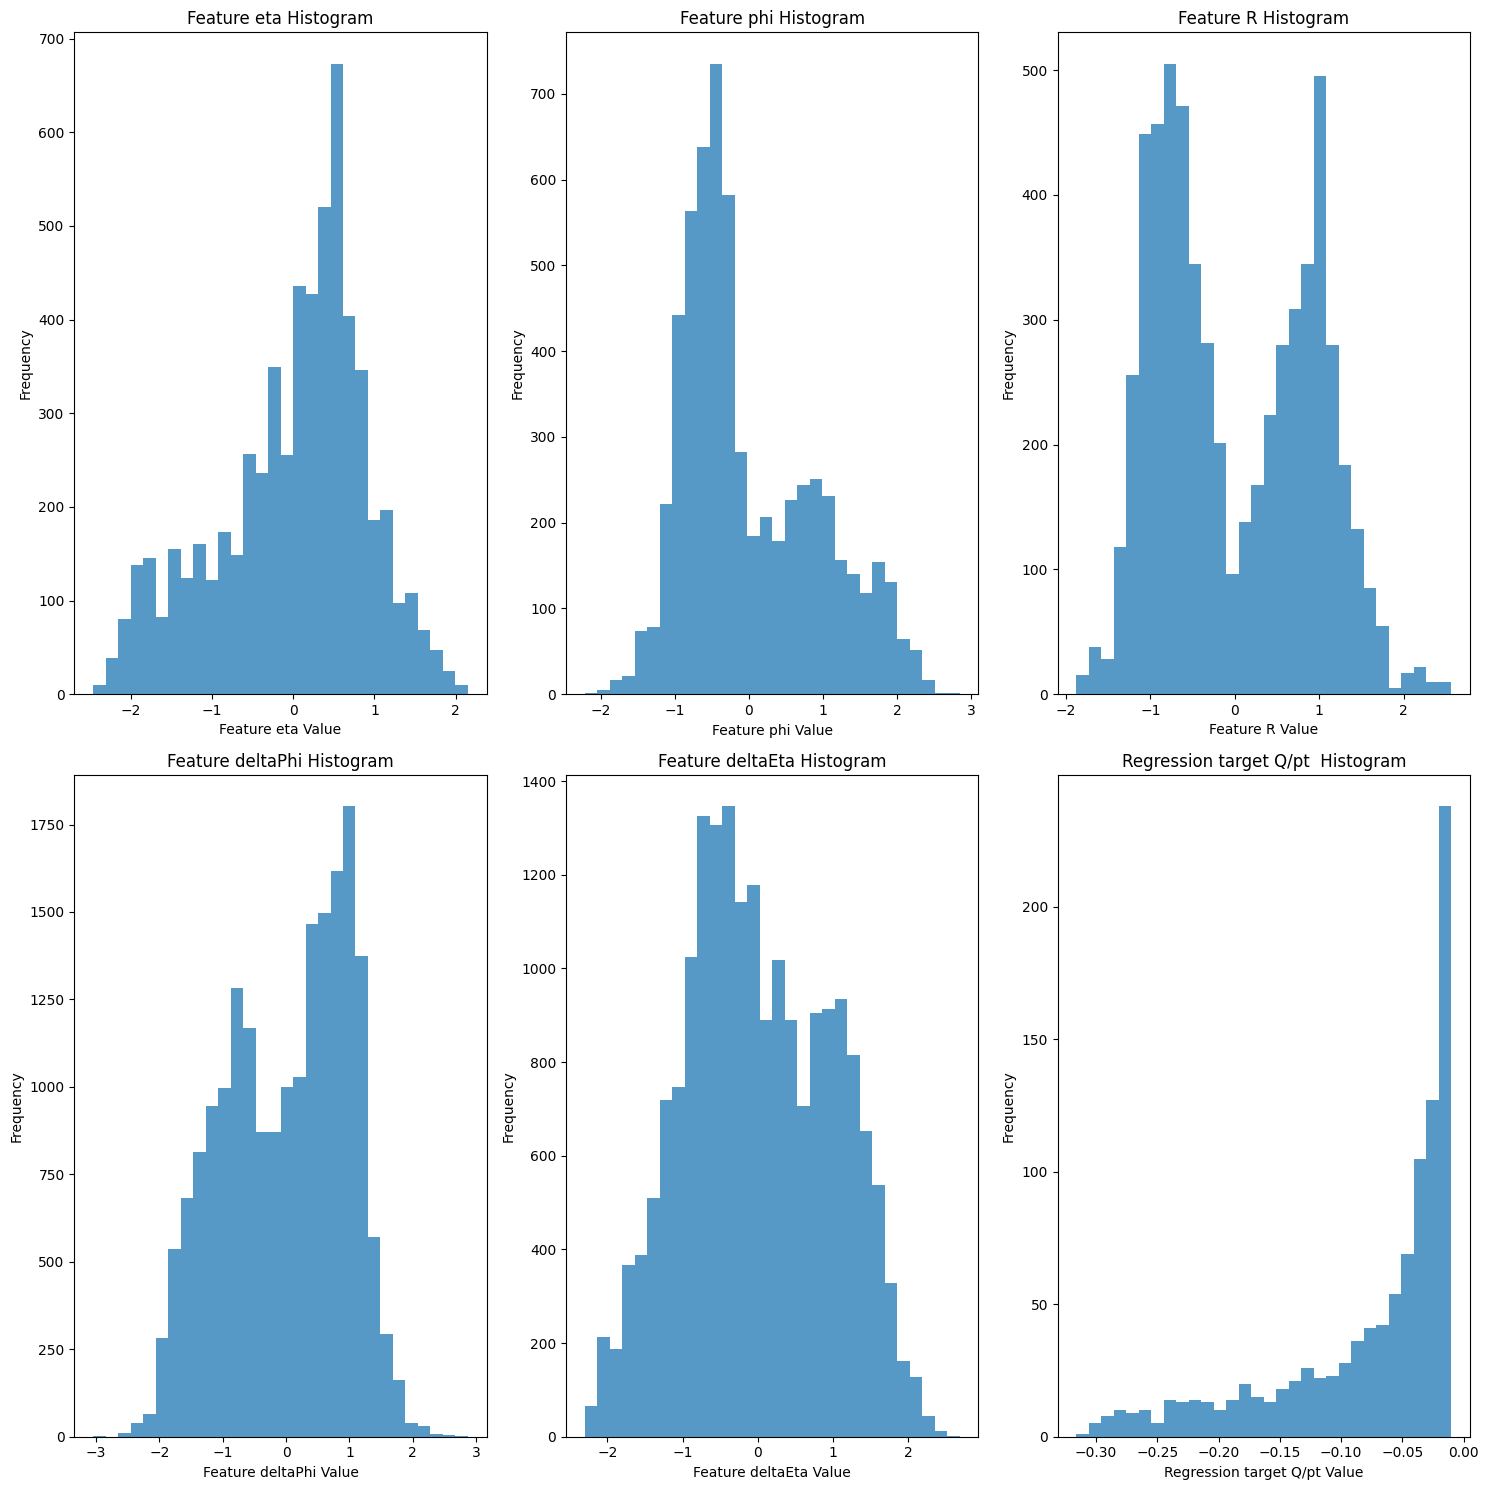

In [ ]:
import matplotlib.pyplot as plt

# Function to plot histograms for each feature in the same figure

def plot_histograms(data_loader):   
    feature_names = ["eta", "phi", "R",  "deltaPhi", "deltaEta","Q/pt"]
    for batch in data_loader:
        features = batch.x.numpy()
        regression = batch.y.numpy()
        num_features = features.shape[1]
        fig, axs = plt.subplots(2, 3, figsize=(15, 15))
        axs = axs.flatten()
        
        # Plot node features
        for i in range(num_features):
            axs[i].hist(features[:, i], bins=30, alpha=0.75)
            axs[i].set_title(f'Feature {feature_names[i]} Histogram')
            axs[i].set_xlabel(f'Feature {feature_names[i]} Value')
            axs[i].set_ylabel('Frequency')
        
        
        # plot the number of edges of each graph
        for i in range(batch.edge_attr.shape[1]):
            axs[i+num_features].hist(batch.edge_attr[:, i], bins=30, alpha=0.75)
            axs[i+num_features].set_title(f'Feature {feature_names[i+num_features]} Histogram')
            axs[i+num_features].set_xlabel(f'Feature {feature_names[i+num_features]} Value')
            axs[i+num_features].set_ylabel('Frequency')
        
        # Plot regression target
        axs[num_features + (batch.edge_attr.shape[1])].hist(regression, bins=30, alpha=0.75)
        axs[num_features + (batch.edge_attr.shape[1])].set_title(f'Regression target {feature_names[-1]}  Histogram')
        axs[num_features + (batch.edge_attr.shape[1])].set_xlabel(f'Regression target {feature_names[-1]} Value')
        axs[num_features + (batch.edge_attr.shape[1])].set_ylabel('Frequency')
              
        plt.tight_layout()
        plt.show()
        break  # Only draw the first batch

# Plot histograms for training data
plot_histograms(train_loader_noNORM)
plot_histograms(train_loader)

## Define model

In [33]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, global_max_pool, global_mean_pool, AttentionalAggregation
from torch_geometric.utils import add_self_loops, degree, softmax

class MPL(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(MPL, self).__init__(aggr='add')
        self.mlp1 = torch.nn.Linear(in_channels*2, out_channels)
        self.mlp2 = torch.nn.Linear(in_channels, out_channels)
        self.mlp3 = torch.nn.Linear(2*out_channels, 1)
        self.mlp4 = torch.nn.Linear(2*out_channels, 1)
        self.mlp5 = torch.nn.Linear(in_channels,16)
        self.mlp6 = torch.nn.Linear(out_channels,16)
        self.mlp7 = torch.nn.Linear(16,1)

    def forward(self, x, edge_index):
#         edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        msg = self.propagate(edge_index, x=x.float())
        x = F.relu(self.mlp2(x))
        w1 = F.sigmoid(self.mlp3(torch.cat([x,msg], dim=1)))
        w2 = F.sigmoid(self.mlp4(torch.cat([x,msg], dim=1)))
        out = w1*msg + w2*x
        
        return out

    def message(self, x_i, x_j, edge_index):
        msg = F.relu(self.mlp1(torch.cat([x_i, x_j-x_i], dim=1)))
        w1 = F.tanh(self.mlp5(x_i))
        w2 = F.tanh(self.mlp6(msg))
        w = self.mlp7(w1*w2)
        w = softmax(w, edge_index[0])
        return msg*w

class MPLNNRegressor(torch.nn.Module):
    def __init__(self,in_channels):
        super(MPLNNRegressor, self).__init__()
        self.conv1 = MPL(in_channels,128 )
        self.conv2 = MPL(128,64)
        self.conv3 = MPL(64,64 )
        self.conv4 = MPL(64,64 )
        self.lin1 = torch.nn.Linear(128, 128)
        self.lin2 = torch.nn.Linear(128, 16)
        self.lin3 = torch.nn.Linear(16, 16)
        self.lin4 = torch.nn.Linear(16, 1)
        self.lin5 = torch.nn.Linear(128, 128)
        self.lin6 = torch.nn.Linear(128, 16)
        self.lin7 = torch.nn.Linear(16, 16)
        self.lin8 = torch.nn.Linear(16, 1)
        self.global_att_pool1 = AttentionalAggregation(torch.nn.Sequential(torch.nn.Linear(64, 1)))
        self.global_att_pool2 = AttentionalAggregation(torch.nn.Sequential(torch.nn.Linear(64, 1)))
    
    def forward(self, data):
        x, edge_index, batch = data.x.float(), data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x1 = self.global_att_pool1(x, batch)
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x2 = self.global_att_pool2(x, batch)
        x_out = torch.cat([x1, x2], dim=1)
        x = F.relu(self.lin1(x_out))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        x = self.lin4(x).squeeze(1)

        return x


In [34]:
from torch_geometric.nn import GATConv

class GATRegressor(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, output_dim=1):
        super(GATRegressor, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_dim, add_self_loops=False)
        self.conv2 = GATConv(hidden_dim, hidden_dim, add_self_loops=False)
        self.fc1 = torch.nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr, data.batch
        
        x = F.relu(x)
        x = self.conv1(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr=edge_attr)
        x = F.relu(x)
        x = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)
        x = self.fc1(x)
        return x
    
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=0.6)
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=False, dropout=0.6)
        self.fc1 = torch.nn.Linear(hidden_channels * 2, out_channels)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = torch.cat([global_max_pool(x, data.batch), global_mean_pool(x, data.batch)], dim=1)
        x = self.fc1(x)       
        return x

from torch_geometric.nn import SAGEConv
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels*4)
        self.conv2 = SAGEConv(hidden_channels*4, hidden_channels*2)
        self.conv3 = SAGEConv(hidden_channels*2, hidden_channels*2)
        self.conv4 = SAGEConv(hidden_channels*2, hidden_channels*2)

        self.lin1 = torch.nn.Linear(hidden_channels*2, hidden_channels*2)
        self.lin2 = torch.nn.Linear(hidden_channels*2, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin4 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x.float(), data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = global_mean_pool(x, data.batch)
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        x = self.lin4(x).squeeze(1)
       
        return x

## Train model

In [35]:
# Definir el modelo, optimizador y la función de pérdida
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_GATRegressor = GATRegressor(num_node_features=3, hidden_dim=32).to(device)
optimizer = torch.optim.Adam(model_GATRegressor.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss()
print(model_GATRegressor)

# Third model: 
model_SAGEModel = GraphSAGEModel(in_channels=3, hidden_channels=32, out_channels=1).to(device)
optimizer_SAGEModel = torch.optim.Adam(model_SAGEModel.parameters(), lr=0.001)
print(model_SAGEModel)

# Fourth model:
model_MPNNRegressor = MPLNNRegressor(in_channels=3).to(device)
optimizer_MPNNRegressor = torch.optim.Adam(model_MPNNRegressor.parameters(), lr=0.001)
print(model_MPNNRegressor)

GATRegressor(
  (conv1): GATConv(3, 32, heads=1)
  (conv2): GATConv(32, 32, heads=1)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)
GraphSAGEModel(
  (conv1): SAGEConv(3, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (conv4): SAGEConv(64, 64, aggr=mean)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=32, bias=True)
  (lin4): Linear(in_features=32, out_features=1, bias=True)
)
MPLNNRegressor(
  (conv1): MPL()
  (conv2): MPL()
  (conv3): MPL()
  (conv4): MPL()
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_featu

In [36]:
# Definir una función para entrenar el modelo
def train_model(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out, data.y.view(out.size()))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Definir una función para evaluar el modelo
@torch.no_grad()
def test_model(model, test_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    for data in test_loader:
        data = data.to(device)
        out = model(data)
        loss = loss_fn(out, data.y.view(out.size()))
        total_loss += loss.item()
    return total_loss / len(test_loader)


In [37]:
do_not_train=True

# Entrenar y evaluar el modelo
num_epochs = 20    
for epoch in range(num_epochs): 
    if do_not_train: break

    GAT_train_loss = train_model(model_GATRegressor, train_loader, optimizer, loss_fn, device)
    GAT_test_loss = test_model(model_GATRegressor, test_loader, loss_fn, device)

    SAGEModel_train_loss = train_model(model_SAGEModel, train_loader, optimizer_SAGEModel, loss_fn, device)
    SAGEModel_test_loss = test_model(model_SAGEModel, test_loader, loss_fn, device)
    
    MPNN_train_loss = train_model(model_MPNNRegressor, train_loader, optimizer_MPNNRegressor, loss_fn, device)
    MPNN_test_loss = test_model(model_MPNNRegressor, test_loader, loss_fn, device)

    # Print the loss for each epoch, in a table of all models: 
    print(f'Epoch {epoch+1:3d}/{num_epochs:3d}, GAT Loss: {GAT_train_loss:.4f} ({GAT_test_loss:.4f}) | SAGEModel Loss: {SAGEModel_train_loss:.4f} ({SAGEModel_test_loss:.4f}) | MPNN Loss: {MPNN_train_loss:.4f} ({MPNN_test_loss:.4f})')


In [38]:
# Save the model
if not os.path.exists(ModelOutDIR) and not do_not_train:
    os.makedirs(ModelOutDIR)

    torch.save(model_GATRegressor.state_dict(), f'{ModelOutDIR}model_GATRegressor_{BatchSize}batches_{num_epochs}epochs_3_32_32_1.pth')
    torch.save(model_SAGEModel.state_dict(), f'{ModelOutDIR}model_SAGEModel_{BatchSize}batches_{num_epochs}epochs_3_128_64_32_1.pth')
    torch.save(model_MPNNRegressor.state_dict(), f'{ModelOutDIR}model_MPNNRegressor_{BatchSize}batches_{num_epochs}epochs_4MPL_8Lins.pth')

## Validate model

In [ ]:
## Plot the results
import numpy as np

def remove_outliers(data, m=1.5):
    data = np.array(data)
    median = np.median(data)
    diff = np.abs(data - median)
    mad = np.median(diff)
    modified_z_score = 0.6745 * diff / mad
    return data[modified_z_score < m]

def evaluate_model(model, test_loader, device):
    model.eval()
    total_loss = 0
    all_regression = []
    all_prediction = []
    with torch.no_grad():
        for data in test_loader:
            #only one batch
            data = data.to(device)
            out = model(data)
            all_regression.append(data.y.cpu().numpy())
            all_prediction.append(out.cpu().numpy())
    
    
    # Concatenar todas las predicciones y valores objetivo
    all_regression = np.concatenate(all_regression, axis=0)
    all_prediction = np.concatenate(all_prediction, axis=0)
    
    return all_regression, all_prediction

regression_list = []
prediction_list = []



## Load model from file: 
if do_not_train:
    model_GATRegressor.load_state_dict(torch.load(f'{ModelOutDIR}model_GATRegressor_{BatchSize}batches_{num_epochs}epochs_3_32_32_1.pt', map_location=device))
    model_SAGEModel.load_state_dict(torch.load(f'{ModelOutDIR}model_SAGEModel_{BatchSize}batches_{num_epochs}epochs_3_128_64_32_1.pt', map_location=device))
    model_MPNNRegressor.load_state_dict(torch.load(f'{ModelOutDIR}model_MPNNRegressor_{BatchSize}batches_{num_epochs}epochs_4MPL_8Lins.pt', map_location=device))

for model in [model_GATRegressor, model_SAGEModel,model_MPNNRegressor]:
    print(f'Evaluating model {model}')
    regression, prediction = evaluate_model(model, test_loader, device)
    regression_list.append((regression))
    prediction_list.append((prediction))


Evaluating model GATRegressor(
  (conv1): GATConv(3, 32, heads=1)
  (conv2): GATConv(32, 32, heads=1)
  (fc1): Linear(in_features=64, out_features=1, bias=True)
)


/var/folders/08/4qyj2h792lv7kk8b3phm_j000000gn/T/ipykernel_71433/1898940008.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_SAGEModel.load_state_dict(torch.load(f

Evaluating model GraphSAGEModel(
  (conv1): SAGEConv(3, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 64, aggr=mean)
  (conv4): SAGEConv(64, 64, aggr=mean)
  (lin1): Linear(in_features=64, out_features=64, bias=True)
  (lin2): Linear(in_features=64, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=32, bias=True)
  (lin4): Linear(in_features=32, out_features=1, bias=True)
)
Evaluating model MPLNNRegressor(
  (conv1): MPL()
  (conv2): MPL()
  (conv3): MPL()
  (conv4): MPL()
  (lin1): Linear(in_features=128, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=16, bias=True)
  (lin4): Linear(in_features=16, out_features=1, bias=True)
  (lin5): Linear(in_features=128, out_features=128, bias=True)
  (lin6): Linear(in_features=128, out_features=16, bias=True)
  (lin7): Linear(in_features=16, out_features=16, bias=True)
  (lin8): Linear(in_features=16,

In [ ]:
def plot_results(all_regression, all_prediction, label='Model'):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    print("Plotting Regression target")
    axs[0].hist(all_regression, bins=np.arange(-0.5,0,0.006), alpha=0.75, label='Regression target')
    axs[0].hist(all_prediction, bins=np.arange(-0.5,0,0.006), alpha=0.75, label='Prediction')
    axs[0].set_title(f'Regression target and prediction for {label}')
    axs[0].set_xlabel('Value')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    axs[1].scatter(all_regression, all_prediction, alpha=0.5)
    axs[1].plot([min(all_prediction), max(all_prediction)], [min(all_prediction), max(all_prediction)], color='red', linestyle='--') # Line of equality
    axs[1].set_title(f'Regression target vs prediction for {label}')
    axs[1].set_xlabel('Regression target')
    axs[1].set_ylabel('Prediction')

    axs[2].hist(all_prediction - all_regression, bins=30, alpha=0.75)
    axs[2].set_title(f'Residuals for {label}')
    axs[2].set_xlabel('Residual')
    axs[2].set_ylabel('Frequency')
    
    # Calculate the bias and resolution and plot them in the graph
    bias = np.mean(all_prediction - all_regression)
    resolution = np.std(all_prediction - all_regression)

    # Add text box with bias and resolution
    textstr = f'Bias: {bias:.4f}\nResolution: {resolution:.4f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[1].text(0.95, 0.95, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', horizontalalignment='right', bbox=props)


    plt.tight_layout()
    plt.show()



Plotting results for model: SAGEModel
Plotting Regression target


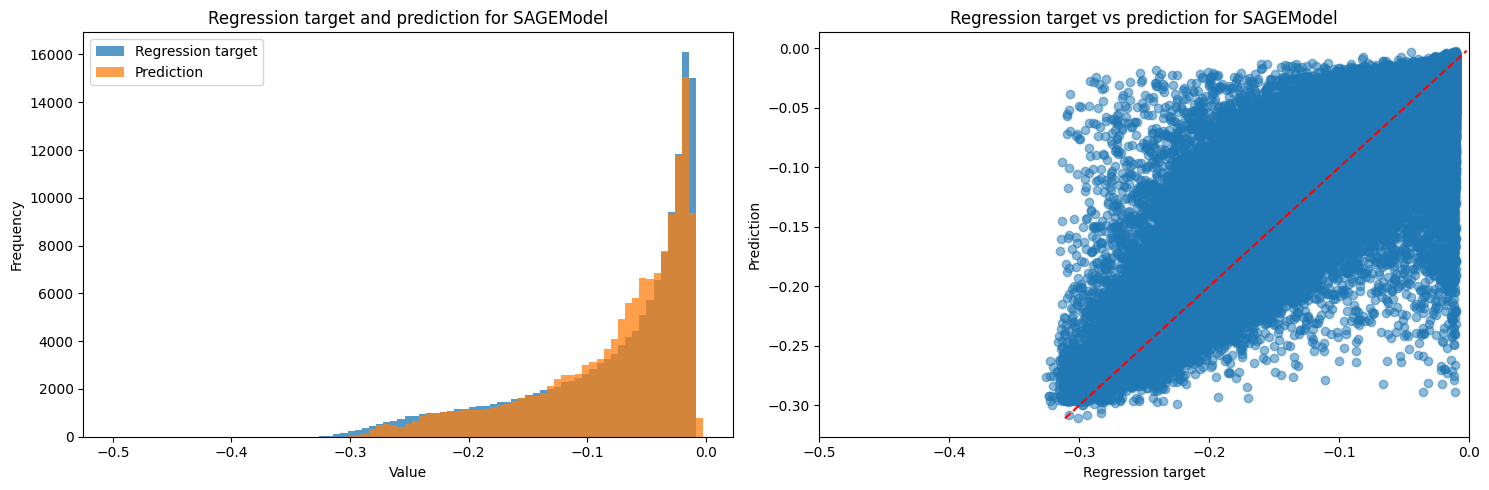

Plotting results for model: MPNNRegressor
Plotting Regression target


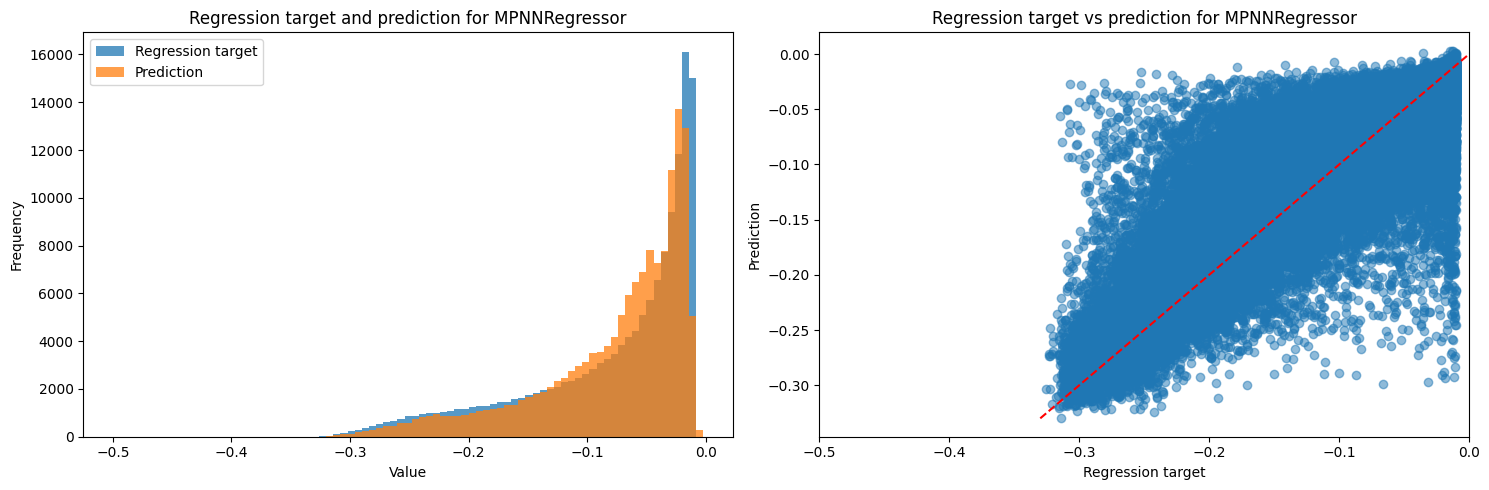

In [48]:
labels = ['GAT','SAGEModel','MPNNRegressor']

for i in range(len(labels)): 
    if i == 0: continue
    print(f'Plotting results for model: {labels[i]}')
    plot_results(regression_list[i], prediction_list[i], label=labels[i])

## Check accuracy and other metrics